## ⬇️ 1. Downloading the dataset (emmarex/plantdisease)
✅ Dataset found (read-only) at: C:\Users\noemo\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1

## 🔄 2. Copy to writable folder and clean (Consolidation)
   -> Copying C:\Users\noemo\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1 to C:\Users\noemo\OneDrive\Documents\GitHub\ML-Project\notebooks\plantdisease_working...
💡 Found single subdirectory ('PlantVillage'). Attempting to flatten structure...
❌ Error moving PlantVillage: Destination path 'C:\Users\noemo\OneDrive\Documents\GitHub\ML-Project\notebooks\plantdisease_working\PlantVillage' already exists
✅ Flattening done.

## 🗂️ 3. Image indexing and partition creation
   -> 20638 images found for 15 classes.


C:\Users\noemo\AppData\Local\Temp\ipykernel_27124\679432762.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


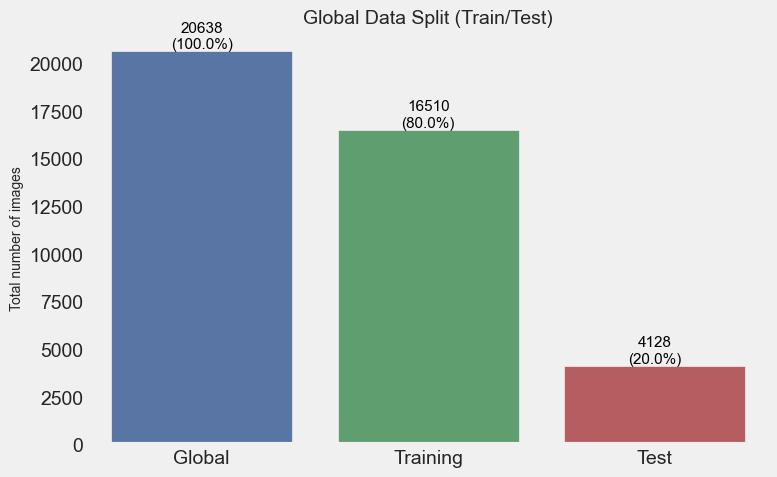


## 📊 4. Visualizing Class Proportions (Grouped Bars)
✅ Grouped class proportions plot generated.


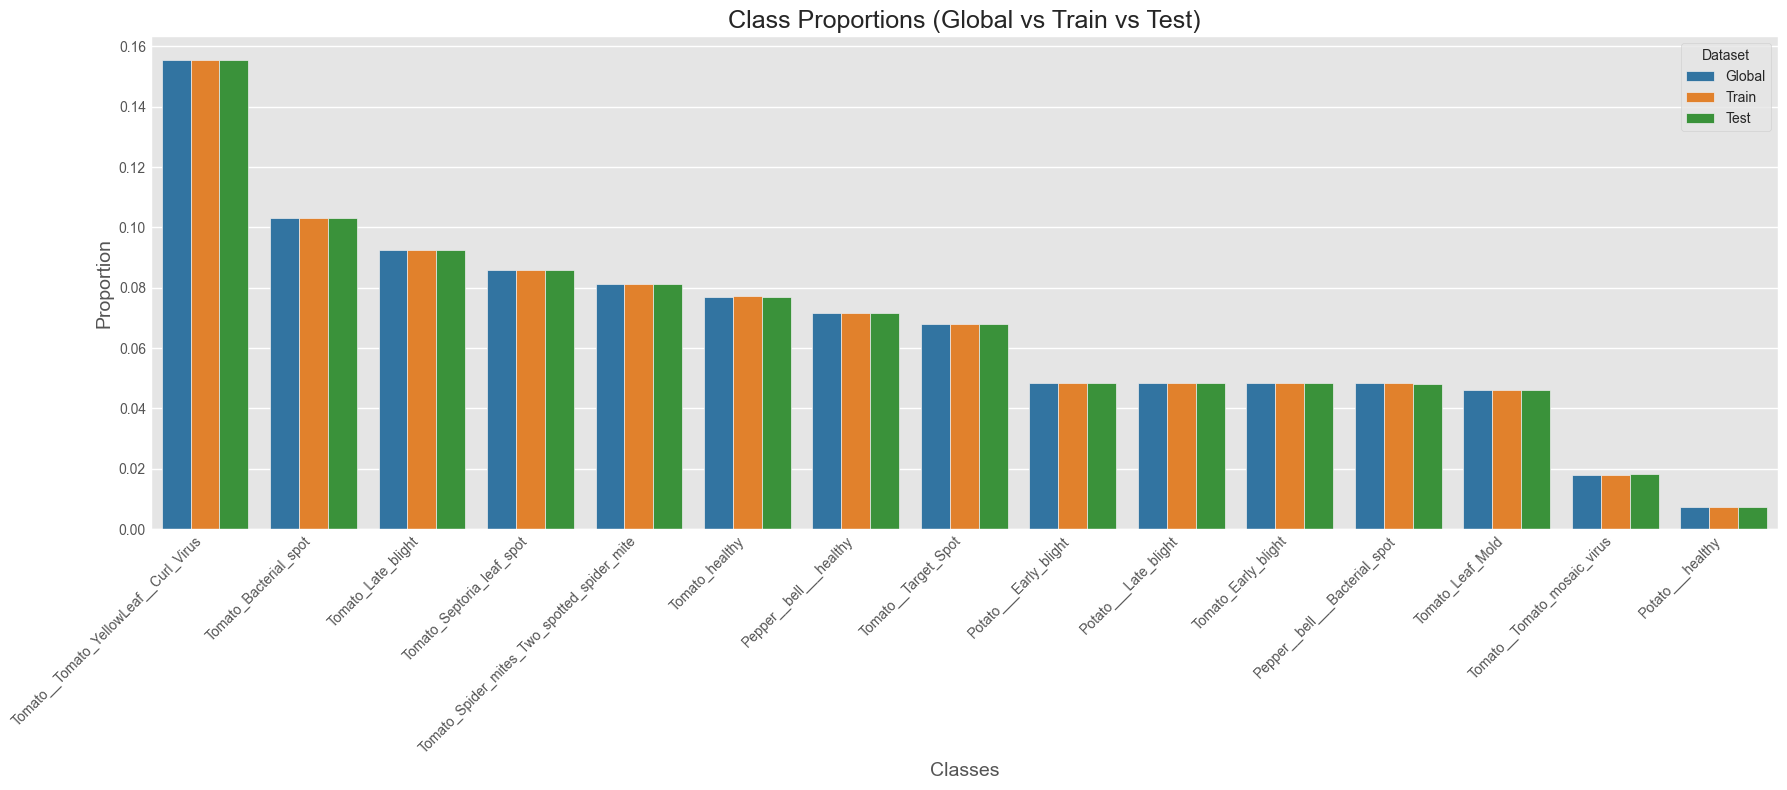


                DETAILED CLASS DISTRIBUTION (COUNTS AND PERCENTAGES)
                                             Global Count  Training Count  \
label                                                                       
Pepper__bell___Bacterial_spot                         997             798   
Pepper__bell___healthy                               1478            1182   
Potato___Early_blight                                1000             800   
Potato___Late_blight                                 1000             800   
Potato___healthy                                      152             122   
Tomato_Bacterial_spot                                2127            1701   
Tomato_Early_blight                                  1000             800   
Tomato_Late_blight                                   1909            1527   
Tomato_Leaf_Mold                                      952             762   
Tomato_Septoria_leaf_spot                            1771            1417   
Tomato

In [1]:
import os
import pickle
import shutil
from collections import defaultdict
from pathlib import Path
from typing import List, Tuple

import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# ====================================================================
#                      CONFIGURATION AND CONSTANTS
# ====================================================================
DATASET_REF        = "emmarex/plantdisease"
WORKING_DIR_NAME   = "plantdisease_working"  # Writable copy of the dataset
ALLOWED_EXTS       = {".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG", ".BMP"}
MAX_PER_CLASS      = 100000  # Cap images per class

# In a Jupyter Notebook __file__ is not defined. Use the current working directory
# so artifacts are created relative to where the notebook is executed.
ARTIFACTS_DIR      = Path.cwd() / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)


# ====================================================================
#                           UTILITY FUNCTIONS
# ====================================================================
def _find_class_dirs(root: Path) -> List[Path]:
    """Find every folder containing images and treat it as a class."""
    class_dirs = []
    for p in root.iterdir():
        if p.is_dir() and any(f.is_file() and f.suffix.lower() in ALLOWED_EXTS for f in p.iterdir()):
            class_dirs.append(p)
    return sorted(class_dirs, key=lambda x: x.name)


def consolidate_dataset(read_only_path: str) -> str:
    """
    Copy the dataset to a writable folder and consolidate/flatten the structure
    by moving the contents of the deepest folder up to the base level if necessary.
    This resolves read-only errors and ensures the returned path is the direct 
    parent of all class directories.
    """
    print(f"\n## 🔄 2. Copy to writable folder and clean (Consolidation)")

    working_base_dir = Path(os.getcwd()) / WORKING_DIR_NAME
    if working_base_dir.exists():
        shutil.rmtree(working_base_dir)

    print(f"   -> Copying {read_only_path} to {working_base_dir}...")
    shutil.copytree(read_only_path, working_base_dir)
    base_dir = working_base_dir

    # --- Flattening Logic (Drop deepest folders if structure is too deep) ---
    top_level_items = [p for p in base_dir.iterdir() if p.is_dir()]

    if len(top_level_items) == 1:
        source_dir = top_level_items[0] 
        print(f"💡 Found single subdirectory ('{source_dir.name}'). Attempting to flatten structure...")

        for item in source_dir.iterdir():
            try:
                # Move the item (folder or file) to the base_dir
                shutil.move(str(item), str(base_dir))
            except Exception as e:
                print(f"❌ Error moving {item.name}: {e}")
                
        shutil.rmtree(source_dir)
        print("✅ Flattening done.")
    
    # --- Final Class Root Identification ---
    # Check for 'PlantVillage' folder, which should contain the class directories
    target_root = base_dir / 'PlantVillage' 

    if target_root.is_dir():
        return str(target_root)
    
    # Check if base_dir now contains class folders directly
    if _find_class_dirs(base_dir):
        return str(base_dir)
    
    raise RuntimeError("Could not determine the dataset root containing class directories.")


def plot_split_distribution(df_global: pd.DataFrame, train_df: pd.DataFrame, test_df: pd.DataFrame):
    """Displays a bar chart showing the size and percentage split of Global/Training/Test sets."""
    
    data = {
        'Set': ['Global', 'Training', 'Test'],
        'Size': [len(df_global), len(train_df), len(test_df)]
    }
    split_df = pd.DataFrame(data)
    total_samples = len(df_global)

    # Create the chart
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(8, 5))
    
    ax = sns.barplot(
        x='Set', 
        y='Size', 
        data=split_df, 
        palette=['#4c72b0', '#55a868', '#c44e52']
    )
    
    # Add value labels (Count + Percentage)
    for index, row in split_df.iterrows():
        percentage = (row['Size'] / total_samples) * 100
        label = f"{row['Size']}\n({percentage:.1f}%)" 
        
        ax.text(row.name, row.Size, label, 
                color='black', ha="center", va='bottom', fontsize=11)
        
    ax.set_title("Global Data Split (Train/Test)", fontsize=14)
    ax.set_ylabel("Total number of images", fontsize=10)
    ax.set_xlabel("")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


def plot_class_proportions_grouped(combined_df_long: pd.DataFrame):
    """
    Plots a grouped bar chart showing the proportion of each class 
    in Global, Train, and Test sets, inspired by the reference image.
    """
    print("✅ Grouped class proportions plot generated.")
    
    plt.style.use('ggplot')
    # Use a large size to accommodate many classes on the x-axis
    plt.figure(figsize=(18, 8)) 
    
    # Plotting the grouped bar chart
    ax = sns.barplot(
        data=combined_df_long,
        x='Class',
        y='Proportion',
        hue='Set',
        palette='tab10' # A palette with distinct colors for the three sets
    )
    
    ax.set_title("Class Proportions (Global vs Train vs Test)", fontsize=18)
    ax.set_ylabel("Proportion", fontsize=14)
    ax.set_xlabel("Classes", fontsize=14)
    
    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=10)
    
    # Optional: Adjust legend location
    plt.legend(title='Dataset', loc='upper right')
    
    plt.tight_layout()
    plt.show()


def _print_class_distribution_summary(summary_df: pd.DataFrame, total_global: int, total_train: int, total_test: int):
    """
    Prints a consolidated table showing class distribution 
    in absolute counts and percentages for Global, Training, and Test sets.
    (Auxiliary function for printout only)
    """
    
    # Format the DataFrame for better display
    summary_df = summary_df.sort_index()
    
    # Set display format for percentages
    pd.options.display.float_format = '{:,.2f}%'.format
    
    print("\n" + "="*80)
    print("                DETAILED CLASS DISTRIBUTION (COUNTS AND PERCENTAGES)")
    print("="*80)
    
    # Rename columns for final output clarity
    display_df = summary_df.copy()
    display_df.columns = [
        'Global Count', 'Training Count', 'Test Count', 
        'Global %', 'Training %', 'Test %'
    ]
    
    # Display the full table
    print(display_df)
    
    # Print overall totals
    print("\n" + "-"*80)
    print(f"TOTAL GLOBAL IMAGES: {total_global}")
    print(f"TOTAL TRAINING IMAGES: {total_train} ({(total_train / total_global) * 100:.2f}%)")
    print(f"TOTAL TEST IMAGES: {total_test} ({(total_test / total_global) * 100:.2f}%)")
    print("-" * 80)
    
    # Reset pandas display format
    pd.options.display.float_format = None


def analyze_class_distribution(df_global: pd.DataFrame, train_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Calculates statistics, plots the grouped proportions chart, and prints the summary table.
    """
    
    # --- 1. Data Calculation (for Table and Plot) ---
    
    # Calculate counts and proportions (which is count / total_count)
    sets_data = {
        'Global': df_global,
        'Train': train_df,
        'Test': test_df
    }
    
    proportions_list = []
    
    for name, df in sets_data.items():
        counts = df['label'].value_counts()
        total = len(df)
        proportions = (counts / total).reset_index()
        proportions.columns = ['Class', 'Proportion']
        proportions['Set'] = name
        proportions_list.append(proportions)
    
    # Create the long format DataFrame for plotting
    combined_df_long = pd.concat(proportions_list, ignore_index=True)
    
    # Calculate Counts and Percentages for the summary table
    global_counts = df_global['label'].value_counts().rename('Global Count')
    train_counts = train_df['label'].value_counts().rename('Training Count')
    test_counts = test_df['label'].value_counts().rename('Test Count')
    
    summary_df = pd.concat([global_counts, train_counts, test_counts], axis=1).fillna(0).astype(int)
    
    total_global = len(df_global)
    total_train = len(train_df)
    total_test = len(test_df)
    
    summary_df['Global %'] = (summary_df['Global Count'] / total_global) * 100
    summary_df['Training %'] = (summary_df['Training Count'] / total_train) * 100
    summary_df['Test %'] = (summary_df['Test Count'] / total_test) * 100
    
    # --- 2. Plotting (Grouped Proportions) ---
    print("\n## 📊 4. Visualizing Class Proportions (Grouped Bars)")
    plot_class_proportions_grouped(combined_df_long)
    
    # --- 3. Printing the Summary Table ---
    _print_class_distribution_summary(summary_df, total_global, total_train, total_test)


def build_dataframe(dataset_root: Path) -> Tuple[pd.DataFrame, dict]:
    """Walk the class tree and build a path/label DataFrame. """
    records = []
    class_counts = defaultdict(int)

    for class_dir in _find_class_dirs(dataset_root):
        for img_path in class_dir.iterdir():
            if img_path.is_file() and img_path.suffix.lower() in ALLOWED_EXTS:
                if class_counts[class_dir.name] >= MAX_PER_CLASS:
                    continue
                records.append({"path": str(img_path.resolve()), "label": class_dir.name})
                class_counts[class_dir.name] += 1

    df = pd.DataFrame(records)
    if df.empty:
        raise RuntimeError("No valid images found in the consolidated dataset.")

    return df, class_counts


def save_artifacts(train_df: pd.DataFrame, test_df: pd.DataFrame, binarizer: LabelBinarizer) -> None:
    """Save split DataFrames and binarizer."""
    train_path = ARTIFACTS_DIR / "train_df.csv"
    test_path = ARTIFACTS_DIR / "test_df.csv"
    binarizer_path = ARTIFACTS_DIR / "label_binarizer.pkl"

    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)
    with open(binarizer_path, "wb") as f:
        pickle.dump(binarizer, f)

    print(f"\n✅ Artifacts saved in {ARTIFACTS_DIR}")
    print(f"   - {train_path.name} ({len(train_df)} samples)")
    print(f"   - {test_path.name} ({len(test_df)} samples)")
    print(f"   - {binarizer_path.name}")


def main():
    print(f"## ⬇️ 1. Downloading the dataset ({DATASET_REF})")
    try:
        read_only_path = kagglehub.dataset_download(DATASET_REF)
        print(f"✅ Dataset found (read-only) at: {read_only_path}")

        # Nettoyage et copie vers le répertoire inscriptible
        directory_root = consolidate_dataset(read_only_path)
    except Exception as e:
        print(f"❌ Critical error: {e}")
        return

    print("\n## 🗂️ 3. Image indexing and partition creation")
    dataset_root = Path(directory_root)
    df, class_counts = build_dataframe(dataset_root)
    print(f"   -> {len(df)} images found for {len(class_counts)} classes.")

    # Division des données
    train_df, test_df = train_test_split(
        df,
        test_size=0.2,
        stratify=df["label"],
        random_state=42
    )

    # 1. Visualisation de la répartition globale (Résumé de haut niveau)
    plot_split_distribution(df, train_df, test_df)

    # 2. Analyse détaillée des classes (Graphique de barres groupées et Tableau)
    analyze_class_distribution(df, train_df, test_df)

    # Ajustement du binariseur uniquement sur l'entraînement
    binarizer = LabelBinarizer()
    binarizer.fit(train_df["label"])

    save_artifacts(train_df, test_df, binarizer)


if __name__ == "__main__":
    main()